In [1]:
%env CUDA_VISIBLE_DEVICES=1

env: CUDA_VISIBLE_DEVICES=1


In [2]:
import os
import numpy as np
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import cv2
from PIL import Image
from random import shuffle
from tqdm import tqdm
import pandas as pd

import pickle

from sklearn.svm import SVC,LinearSVC
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier,ExtraTreesClassifier
from sklearn.neural_network import MLPClassifier
from sklearn import preprocessing

#from scipy.misc import imread, imresize

%matplotlib inline

In [3]:
def log_progress(sequence, every=None, size=None, name='Items'):
    from ipywidgets import IntProgress, HTML, VBox
    from IPython.display import display

    is_iterator = False
    if size is None:
        try:
            size = len(sequence)
        except TypeError:
            is_iterator = True
    if size is not None:
        if every is None:
            if size <= 200:
                every = 1
            else:
                every = int(size / 200)     # every 0.5%
    else:
        assert every is not None, 'sequence is iterator, set every'

    if is_iterator:
        progress = IntProgress(min=0, max=1, value=1)
        progress.bar_style = 'info'
    else:
        progress = IntProgress(min=0, max=size, value=0)
    label = HTML()
    box = VBox(children=[label, progress])
    display(box)

    index = 0
    try:
        for index, record in enumerate(sequence, 1):
            if index == 1 or index % every == 0:
                if is_iterator:
                    label.value = '{name}: {index} / ?'.format(
                        name=name,
                        index=index
                    )
                else:
                    progress.value = index
                    label.value = u'{name}: {index} / {size}'.format(
                        name=name,
                        index=index,
                        size=size
                    )
            yield record
    except:
        progress.bar_style = 'danger'
        raise
    else:
        progress.bar_style = 'success'
        progress.value = index
        label.value = "{name}: {index}".format(
            name=name,
            index=str(index or '?')
        )

In [4]:
ALL_DATA_DIR = '/home/HDD6TB/datasets/emotions/'
INPUT_SIZE = (224, 224)
#INPUT_SIZE = (299, 299)

---

# AffectNet

In [5]:
AFFECT_DATA_DIR=ALL_DATA_DIR+'AffectNet/'
AFFECT_TRAIN_DATA_DIR = AFFECT_DATA_DIR+'full_res/train'
AFFECT_VAL_DATA_DIR = AFFECT_DATA_DIR+'full_res/val'
AFFECT_IMG_TRAIN_DATA_DIR = AFFECT_DATA_DIR+str(INPUT_SIZE[0])+'/train'
AFFECT_IMG_VAL_DATA_DIR = AFFECT_DATA_DIR+str(INPUT_SIZE[0])+'/val'
AFFECT_TRAIN_ORIG_DATA_DIR = AFFECT_DATA_DIR+'orig/train'
AFFECT_VAL_ORIG_DATA_DIR = AFFECT_DATA_DIR+'orig/val'

AFFECT_TRAIN_FACES_DATA_DIR = AFFECT_DATA_DIR+'faces/train'
AFFECT_VAL_FACES_DATA_DIR = AFFECT_DATA_DIR+'faces/val'

AFFECT_IMG_SEVEN_TRAIN_DATA_DIR = AFFECT_DATA_DIR+str(INPUT_SIZE[0])+'/seven_emotions/train'
AFFECT_IMG_SEVEN_VAL_DATA_DIR = AFFECT_DATA_DIR+str(INPUT_SIZE[0])+'/seven_emotions/val'

IMG_AFFECT_DATA_DIR = AFFECT_DATA_DIR+'Manually_Annotated_Images/'

Index(['subDirectory_filePath', 'face_x', 'face_y', 'face_width',
       'face_height', 'facial_landmarks', 'expression', 'valence', 'arousal'],
      dtype='object')
689/737db2483489148d783ef278f43f486c0a97e140fc4b6b61b84363ca.jpg 134.0 134.0 899 899 1
392/c4db2f9b7e4b422d14b6e038f0cdc3ecee239b55326e9181ee4520f9.jpg 20.0 20.0 137 137 0
468/21772b68dc8c2a11678c8739eca33adb6ccc658600e4da2224080603.jpg 11.0 11.0 176 176 0
944/06e9ae8d3b240eb68fa60534783eacafce2def60a86042f9b7d59544.jpg 40.0 40.0 269 269 1
993/02e06ee5521958b4042dd73abb444220609d96f57b1689abbe87c024.jpg 22.0 22.0 153 153 8


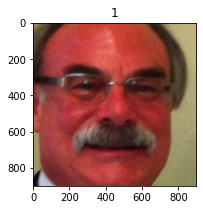

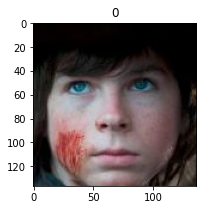

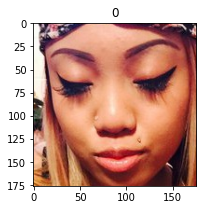

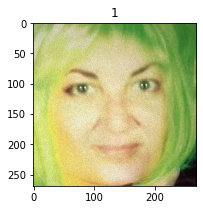

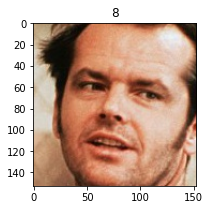

In [6]:
affect_df = pd.read_csv(AFFECT_TRAIN_FILE)
print(affect_df.columns)
#affect_df.head()

affect_df=affect_df.drop(columns=['facial_landmarks', 'valence', 'arousal'])
#affect_df.head()

for i,d in affect_df.iterrows():
    if i>=5:
        break
    print(d.subDirectory_filePath,d.face_x,d.face_y, d.face_width, d.face_height, d.expression)
    plt.figure(figsize=(3, 3))
    img=cv2.imread(os.path.join(IMG_AFFECT_DATA_DIR,d.subDirectory_filePath))
    x,y=int(d.face_x),int(d.face_y)
    w,h=int(d.face_width),int(d.face_height)
    img=img[y:y+h,x:x+w]
    img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    descr=str(d.expression)
    plt.title(descr)
plt.show()

In [17]:
express_np=affect_df.expression.values
print(express_np.min(),express_np.max())
print(np.histogram(express_np))

0 10
(array([ 74874, 134416,  25459,  14090,   6378,   3803,  24882,   3750,
        33088,  94060]), array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]))


In [6]:
emotion_labels=['Neutral','Happiness', 'Sadness', 'Surprise', 'Fear', 'Disgust', 'Anger', 'Contempt']
def save_images(filename,dir_to_save, same_size=-1, extractROI=True):
    affect_df = pd.read_csv(filename)
    affect_vals=[d for i,d in affect_df.iterrows()]
    for d in log_progress(affect_vals):
        #print(d.subDirectory_filePath,d.face_x,d.face_y, d.face_width, d.face_height, d.expression)
        if d.expression>=len(emotion_labels) or d.face_width<0:
            continue
        input_path=os.path.join(IMG_AFFECT_DATA_DIR,d.subDirectory_filePath)
        outdir_path=os.path.join(dir_to_save,emotion_labels[d.expression])
        if not os.path.exists(outdir_path):
            os.makedirs(outdir_path)
        dst_file_path=os.path.join(outdir_path,os.path.basename(d.subDirectory_filePath))
        #print(input_path,dst_file_path)
        if not os.path.exists(dst_file_path):
            if extractROI:
                img=cv2.imread(input_path)
                x,y=int(d.face_x),int(d.face_y)
                w,h=int(d.face_width),int(d.face_height)
                area=img[y:y+h,x:x+w]
                if same_size>0:
                    area = cv2.resize(area,(same_size,same_size))
                cv2.imwrite(dst_file_path,area)
            else:
                os.symlink(input_path,dst_file_path)
        else:
            print('duplicate, several faces?',d.subDirectory_filePath)

In [10]:
save_images(AFFECT_TRAIN_FILE,AFFECT_TRAIN_DATA_DIR)

In [44]:
save_images(AFFECT_VAL_FILE,AFFECT_VAL_DATA_DIR)

In [14]:
save_images(AFFECT_VAL_FILE,AFFECT_IMG_VAL_DATA_DIR,INPUT_SIZE[0])

In [15]:
save_images(AFFECT_TRAIN_FILE,AFFECT_IMG_TRAIN_DATA_DIR,INPUT_SIZE[0])

In [43]:
save_images(AFFECT_VAL_FILE,AFFECT_VAL_ORIG_DATA_DIR,-1, False)
save_images(AFFECT_TRAIN_FILE,AFFECT_TRAIN_ORIG_DATA_DIR,-1, False)

Create directories AFFECT_IMG_SEVEN_TRAIN_DATA_DIR and AFFECT_IMG_SEVEN_VAL_DATA_DIR manually.
The typical sequence of commands in Linux:
mkdir seven_emotions
mkdir seven_emotions/train
mkdir seven_emotions/val
cd seven_emotions/
for emo in Anger Disgust Fear Happiness Neutral Sadness Surprise; \
do ln -s /home/HDD6TB/datasets/emotions/AffectNet/224/train/$emo train/$emo; \
ln -s /home/HDD6TB/datasets/emotions/AffectNet/224/val/$emo val/$emo;done

# Train

In [6]:
import tensorflow as tf
from tensorflow.keras.models import Model,Sequential, load_model,model_from_json
from tensorflow.keras.applications import mobilenet,mobilenet_v2,densenet,inception_resnet_v2,inception_v3,vgg16,resnet_v2,resnet
#from tensorflow.keras.utils.generic_utils import CustomObjectScope
from tensorflow.keras.layers import Flatten, Dense, Dropout,GlobalAveragePooling2D,Activation, Conv2D, Reshape,DepthwiseConv2D,Input
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, Callback, CSVLogger, EarlyStopping
from tensorflow.keras.metrics import top_k_categorical_accuracy
import numpy as np
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.compat.v1.keras.backend import set_session 

INPUT_SIZE = (224, 224)

BATCH_SIZE=40 #512 #64 #32 #64

def save_model(model,filename):
    model.save_weights('weights.h5')
    model_json = model.to_json()
    with open("model.json", "w") as json_file:
        json_file.write(model_json)

    json_file = open('model.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    loaded_model.load_weights('weights.h5')
    loaded_model.save(filename)

In [7]:
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess=tf.compat.v1.Session(config=config)
set_session(sess)

In [8]:
if False:
    if True:
        net_model=mobilenet
        net_description='mobilenet_v1'
        INPUT_SIZE = (224, 224)
        BATCH_SIZE=80
        base_model = mobilenet.MobileNet(input_shape=(INPUT_SIZE[0],INPUT_SIZE[1],3), include_top=True, weights='imagenet')
    else:
        net_model=inception_v3
        net_description='inception_v3'
        INPUT_SIZE = (299, 299)
        BATCH_SIZE=32
        base_model = inception_v3.InceptionV3(input_shape=(INPUT_SIZE[0],INPUT_SIZE[1],3), include_top=True, weights='imagenet')
    preprocessing_function=net_model.preprocess_input
else:
    base_model=load_model('../models/pretrained_faces/age_gender_tf2_224_deep-03-0.13-0.97.h5')
    base_model.summary()
    net_description='mobilenet_face'
    def mobilenet_preprocess_input(x,**kwargs):
        x[..., 0] -= 103.939
        x[..., 1] -= 116.779
        x[..., 2] -= 123.68
        return x
    preprocessing_function=mobilenet_preprocess_input
        
    BATCH_SIZE=80
    INPUT_SIZE = (224, 224)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 32) 864         conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 32) 128         conv1[0][0]                      
____________________________________________________________________________________________

In [9]:
net_description='affectnet_'+net_description
#train_data_dir,val_data_dir=AFFECT_IMG_TRAIN_DATA_DIR,AFFECT_IMG_VAL_DATA_DIR
#train_data_dir,val_data_dir=AFFECT_TRAIN_DATA_DIR,AFFECT_VAL_DATA_DIR
#train_data_dir,val_data_dir=AFFECT_TRAIN_ORIG_DATA_DIR,AFFECT_VAL_ORIG_DATA_DIR
train_data_dir,val_data_dir=AFFECT_IMG_SEVEN_TRAIN_DATA_DIR,AFFECT_IMG_SEVEN_VAL_DATA_DIR
print(train_data_dir,val_data_dir)


/home/HDD6TB/datasets/emotions/AffectNet/224/seven_emotions/train /home/HDD6TB/datasets/emotions/AffectNet/224/seven_emotions/val


In [10]:
def random_crop(x, random_crop_size, sync_seed=None, **kwargs):
    np.random.seed(sync_seed)
    w, h = x.shape[1], x.shape[2]
    rangew = (w - random_crop_size[0]) // 2
    rangeh = (h - random_crop_size[1]) // 2
    offsetw = 0 if rangew == 0 else np.random.randint(rangew)
    offseth = 0 if rangeh == 0 else np.random.randint(rangeh)
    return x[:, offsetw:offsetw+random_crop_size[0], offseth:offseth+random_crop_size[1]]

target_size=INPUT_SIZE
print(target_size)

(224, 224)


In [11]:
if False:
    train_datagen = ImageDataGenerator(featurewise_center=False, samplewise_center=False, featurewise_std_normalization=False, 
                                   samplewise_std_normalization=False, zca_whitening=False, zca_epsilon=1e-06,
                                   rotation_range=0.1, width_shift_range=-0.1, height_shift_range=-0.1, brightness_range=None, shear_range=0.0, 
                                   zoom_range=0.1, channel_shift_range=1.05, fill_mode='nearest', horizontal_flip=True, vertical_flip=False,
                                   preprocessing_function=preprocessing_function)
else:
    train_datagen = ImageDataGenerator(preprocessing_function=preprocessing_function)

test_datagen = ImageDataGenerator(preprocessing_function=preprocessing_function)

In [12]:
val_generator = test_datagen.flow_from_directory(
    val_data_dir, target_size=target_size,
    batch_size=BATCH_SIZE, class_mode='categorical',follow_links=True)

train_generator = train_datagen.flow_from_directory(
    train_data_dir, target_size=target_size,
    batch_size=BATCH_SIZE, class_mode='categorical',follow_links=True)

Found 3500 images belonging to 7 classes.
Found 283901 images belonging to 7 classes.


In [13]:
N_CLASS=val_generator.num_classes
nb_train_samples=train_generator.samples
nb_validation_samples=val_generator.samples
print(N_CLASS,nb_train_samples,nb_validation_samples)

class_to_idx=val_generator.class_indices
idx_to_class={class_to_idx[cls]:cls for cls in class_to_idx}
print(idx_to_class)

7 283901 3500
{0: 'Anger', 1: 'Disgust', 2: 'Fear', 3: 'Happiness', 4: 'Neutral', 5: 'Sadness', 6: 'Surprise'}


In [14]:
(unique, counts) = np.unique(train_generator.classes, return_counts=True)
cw=1/counts
cw/=cw.min()
class_weights = {i:cwi for i,cwi in zip(unique,cw)}
print(counts, class_weights, idx_to_class, val_generator.class_indices)

[ 24882   3803   6378 134415  74874  25459  14090] {0: 5.402097902097902, 1: 35.34446489613463, 2: 21.07478833490122, 3: 1.0, 4: 1.7952159628175335, 5: 5.279665344279037, 6: 9.539744499645138} {0: 'Anger', 1: 'Disgust', 2: 'Fear', 3: 'Happiness', 4: 'Neutral', 5: 'Sadness', 6: 'Surprise'} {'Anger': 0, 'Disgust': 1, 'Fear': 2, 'Happiness': 3, 'Neutral': 4, 'Sadness': 5, 'Surprise': 6}


In [15]:
if False:
    x=base_model.layers[-2].output
else:
    layer_name='feats'
    #layer_name='global_average_pooling2d_1'
    #layer_name='fc7/relu'
    layer_out=base_model.get_layer(layer_name) #'global_pooling') #
    x=layer_out.output

emotion_preds = Dense(N_CLASS, activation='softmax', name='emotion_preds')(x)
model=Model(base_model.input,emotion_preds)
start_epoch=0

In [54]:
base_model.trainable=False
for l in base_model.layers:
    l.trainable=False
model.compile('adam', 'categorical_crossentropy', metrics=['accuracy'])
model.summary()

print(net_description)

mc = ModelCheckpoint(net_description+'.h5', monitor='val_accuracy', verbose=1, save_best_only=True)
es=EarlyStopping(monitor='val_accuracy',patience=2)
FIRST_EPOCHS=3

hist1=model.fit(train_generator, steps_per_epoch=nb_train_samples//BATCH_SIZE, epochs=FIRST_EPOCHS, verbose=1, 
                    initial_epoch=0, callbacks=[mc, es], validation_data=val_generator, validation_steps=nb_validation_samples // BATCH_SIZE,class_weight=class_weights)

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128 

/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/3
3595/3595 [==============================] - 5981s 2s/step - loss: 7.4586 - accuracy: 0.2563 - val_loss: 1.8816 - val_accuracy: 0.2925

Epoch 00001: val_accuracy improved from -inf to 0.29250, saving model to affectnet_orig_my_mobilenet_8.h5
Epoch 2/3
3595/3595 [==============================] - 845s 235ms/step - loss: 7.0581 - accuracy: 0.3019 - val_loss: 1.8788 - val_accuracy: 0.2895

Epoch 00002: val_accuracy did not improve from 0.29250
Epoch 3/3
3595/3595 [==============================] - 850s 236ms/step - loss: 7.0065 - accuracy: 0.3028 - val_loss: 1.8674 - val_accuracy: 0.2952

Epoch 00003: val_accuracy improved from 0.29250 to 0.29525, saving model to affectnet_orig_my_mobilenet_8.h5


In [55]:
start_epoch=len(hist1.history['loss'])
for l in base_model.layers:
    l.trainable=True
    
model.load_weights(net_description+'.h5')
model.compile(optimizer=Adam(lr=1e-4,decay=1e-6), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()
SECOND_EPOCHS=start_epoch+5
mc = ModelCheckpoint(net_description+'_ft.h5', monitor='val_accuracy', verbose=1, save_best_only=True)
#es=EarlyStopping(monitor='val_accuracy',patience=2 )

print('All tuning')
hist2=model.fit(train_generator, steps_per_epoch=train_generator.samples//BATCH_SIZE, epochs=SECOND_EPOCHS, verbose=1, 
                    initial_epoch=start_epoch, validation_data=val_generator, validation_steps=val_generator.samples // BATCH_SIZE, callbacks=[mc],class_weight=class_weights)

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128 

Epoch 4/8
3595/3595 [==============================] - 922s 256ms/step - loss: 5.3155 - accuracy: 0.5101 - val_loss: 1.1908 - val_accuracy: 0.5688

Epoch 00004: val_accuracy improved from -inf to 0.56875, saving model to affectnet_orig_my_mobilenet_8_ft.h5
Epoch 5/8
3595/3595 [==============================] - 917s 255ms/step - loss: 4.0110 - accuracy: 0.5987 - val_loss: 1.1281 - val_accuracy: 0.5915

Epoch 00005: val_accuracy improved from 0.56875 to 0.59150, saving model to affectnet_orig_my_mobilenet_8_ft.h5
Epoch 6/8
2375/3595 [==================>...........] - ETA: 5:08 - loss: 3.6154 - accuracy: 0.6245

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



all classes
orig
enet 3
Epoch 8/9
17978/17978 [==============================] - 9152s 509ms/step - loss: 0.5896 - acc: 0.7877 - val_loss: 1.5385 - val_acc: 0.5188

Epoch 00008: val_acc improved from 0.51425 to 0.51875, saving model to affectnet_enet3_ft.h5


cropped
mobilenet v1
Epoch 8/8
4494/4494 [==============================] - 1234s 275ms/step - loss: 0.4557 - acc: 0.8329 - val_loss: 1.5624 - val_acc: 0.5163

Epoch 00008: val_acc improved from 0.47485 to 0.51626, saving model to affectnet_mobilenet_v1_ft.h5


enet 0
Epoch 6/8
17978/17978 [==============================] - 4915s 273ms/step - loss: 0.3796 - acc: 0.8592 - val_loss: 2.1148 - val_acc: 0.5127
Epoch 00006: val_acc improved from 0.50010 to 0.51270, saving model to affectnet_enet0_ft.h5

inception 3
Epoch 7/8
8989/8989 [==============================] - 2693s 300ms/step - loss: 0.4970 - acc: 0.8178 - val_loss: 1.5130 - val_acc: 0.5310

Epoch 00007: val_acc improved from 0.49550 to 0.53100, saving model to inception_v3_ft.h5

enet 3
Epoch 8/8
17978/17978 [==============================] - 7612s 423ms/step - loss: 0.4615 - acc: 0.8312 - val_loss: 1.6691 - val_acc: 0.5190

Epoch 00008: val_acc improved from 0.51675 to 0.51900, saving model to affectnet_enet3_ft.h5


new class weights
mobilenet_v1
Epoch 3/5
3595/3595 [==============================] - 624s 173ms/step - loss: 6.0336 - acc: 0.4504 - val_loss: 2.4715 - val_acc: 0.2295

Epoch 00003: val_acc improved from 0.22625 to 0.22950, saving model to mobilenet_v1.h5
Epoch 8/10
3595/3595 [==============================] - 1359s 378ms/step - loss: 3.2450 - acc: 0.6539 - val_loss: 1.2269 - val_acc: 0.5687

Epoch 00008: val_acc improved from 0.55425 to 0.56875, saving model to mobilenet_v1_ft.h5
Anger 24882/500 acc: 52.400000
Contempt 3750/500 acc: 50.200000
Disgust 3803/500 acc: 47.400000
Fear 6378/500 acc: 52.800000
Happiness 134415/500 acc: 73.600000
Neutral 74874/500 acc: 63.200000
Sadness 25459/500 acc: 58.800000
Surprise 14090/500 acc: 56.000000


inception
Epoch 5/8
8989/8989 [==============================] - 4176s 465ms/step - loss: 3.9284 - acc: 0.6189 - val_loss: 1.1059 - val_acc: 0.5965

Epoch 00005: val_acc improved from 0.56925 to 0.59650, saving model to affectnet_inception_v3_ft.h5
Anger 24882/500 acc: 66.400000
Contempt 3750/500 acc: 51.400000
Disgust 3803/500 acc: 42.600000
Fear 6378/500 acc: 58.800000
Happiness 134415/500 acc: 77.200000
Neutral 74874/500 acc: 53.000000
Sadness 25459/500 acc: 60.800000
Surprise 14090/500 acc: 51.000000


enet3
17978/17978 [==============================] - 5533s 308ms/step - loss: 7.2364 - acc: 0.3030 - val_loss: 2.4867 - val_acc: 0.1713

Epoch 00001: val_acc improved from -inf to 0.17125, saving model to affectnet_affectnet_enet3.h5
Epoch 00006: val_acc improved from 0.59025 to 0.60275, saving model to affectnet_affectnet_enet3_ft.h5
Epoch 7/8
17978/17978 [==============================] - 7970s 443ms/step - loss: 2.9875 - acc: 0.6705 - val_loss: 1.1917 - val_acc: 0.6068

Anger 24882/500 acc: 49.000000
Contempt 3750/500 acc: 42.800000
Disgust 3803/500 acc: 51.400000
Fear 6378/500 acc: 65.200000
Happiness 134415/500 acc: 79.800000
Neutral 74874/500 acc: 63.600000
Sadness 25459/500 acc: 71.800000
Surprise 14090/500 acc: 56.400000

vggface
Epoch 8/9
5992/5992 [==============================] - 2540s 424ms/step - loss: 4.0993 - acc: 0.5805 - val_loss: 1.2613 - val_acc: 0.5478

Epoch 00008: val_acc improved from 0.53087 to 0.54782, saving model to affectnet_vggface1_ft.h5
Anger 24882/500 acc: 46.000000
Contempt 3750/500 acc: 49.400000
Disgust 3803/500 acc: 51.400000
Fear 6378/500 acc: 56.600000
Happiness 134415/500 acc: 71.800000
Neutral 74874/500 acc: 59.800000
Sadness 25459/500 acc: 56.600000
Surprise 14090/500 acc: 50.800000

vggface2
Epoch 2/5
5992/5992 [==============================] - 2445s 408ms/step - loss: 8.2640 - acc: 0.4664 - val_loss: 2.7049 - val_acc: 0.4087

Epoch 00002: val_acc improved from 0.40788 to 0.40865, saving model to vggface2.h5

Epoch 9/9
5992/5992 [==============================] - 2299s 384ms/step - loss: 2.8767 - acc: 0.6706 - val_loss: 1.2352 - val_acc: 0.5701

Epoch 00009: val_acc improved from 0.56503 to 0.57009, saving model to vggface2_ft.h5
Anger 24882/500 acc: 58.200000
Contempt 3750/500 acc: 51.600000
Disgust 3803/500 acc: 51.600000
Fear 6378/500 acc: 49.000000
Happiness 134415/500 acc: 81.000000
Neutral 74874/500 acc: 42.600000
Sadness 25459/500 acc: 55.400000
Surprise 14090/500 acc: 67.400000


my_mobilenet
vgg16 preprocessing
Epoch 3/5
3595/3595 [==============================] - 588s 164ms/step - loss: 7.0706 - acc: 0.3017 - val_loss: 1.8836 - val_acc: 0.2913

Epoch 00003: val_acc improved from 0.28725 to 0.29125, saving model to affectnet_my_mobilenet.h5

Epoch 9/10
3595/3595 [==============================] - 1200s 334ms/step - loss: 3.2316 - acc: 0.6474 - val_loss: 1.1412 - val_acc: 0.6040

Epoch 00009: val_acc improved from 0.60150 to 0.60400, saving model to affectnet_my_mobilenet_ft.h5
Epoch 11/12
3595/3595 [==============================] - 1332s 370ms/step - loss: 2.6827 - acc: 0.6834 - val_loss: 1.2303 - val_acc: 0.6030

Epoch 00011: val_acc improved from -inf to 0.60300, saving model to affectnet_my_mobilenet_ft_sgd.h5
Anger 24882/500 acc: 61.000000
Contempt 3750/500 acc: 61.600000
Disgust 3803/500 acc: 54.800000
Fear 6378/500 acc: 58.200000
Happiness 134415/500 acc: 70.200000
Neutral 74874/500 acc: 52.800000
Sadness 25459/500 acc: 62.400000
Surprise 14090/500 acc: 62.200000

Epoch 2/5
3595/3595 [==============================] - 592s 165ms/step - loss: 7.0776 - acc: 0.2994 - val_loss: 1.8758 - val_acc: 0.2948

Epoch 00002: val_acc improved from 0.27875 to 0.29475, saving model to my_mobilenet_new1.h5




other preprocessing
Epoch 4/5
3595/3595 [==============================] - 568s 158ms/step - loss: 7.0638 - acc: 0.2954 - val_loss: 1.8776 - val_acc: 0.2958

Epoch 00004: val_acc improved from 0.29125 to 0.29575, saving model to affectnet_my_mobilenet_new.h5
Epoch 8/10
3595/3595 [==============================] - 1224s 340ms/step - loss: 3.5965 - acc: 0.6256 - val_loss: 1.1440 - val_acc: 0.5970

Epoch 00008: val_acc improved from 0.58950 to 0.59700, saving model to affectnet_my_mobilenet_new_ft.h5
Epoch 12/12
3595/3595 [==============================] - 1265s 352ms/step - loss: 2.9799 - acc: 0.6626 - val_loss: 1.1828 - val_acc: 0.5990

Epoch 00012: val_acc improved from 0.59500 to 0.59900, saving model to affectnet_my_mobilenet_new_ft_sgd.h5
Anger 24882/500 acc: 57.400000
Contempt 3750/500 acc: 48.400000
Disgust 3803/500 acc: 53.600000
Fear 6378/500 acc: 62.600000
Happiness 134415/500 acc: 75.600000
Neutral 74874/500 acc: 57.200000
Sadness 25459/500 acc: 62.800000
Surprise 14090/500 acc: 60.600000

mymobilenet_ft_sgd_model.h5
Epoch 12/12
3595/3595 [==============================] - 4006s 1s/step - loss: 2.9808 - acc: 0.6615 - val_loss: 1.1678 - val_acc: 0.6043

Epoch 00012: val_acc improved from 0.60250 to 0.60425, saving model to my_mobilenet_new1_ft_sgd.h5

60.25
Anger 24882/500 acc: 61.800000
Contempt 3750/500 acc: 52.800000
Disgust 3803/500 acc: 55.000000
Fear 6378/500 acc: 64.000000
Happiness 134415/500 acc: 74.200000
Neutral 74874/500 acc: 53.400000
Sadness 25459/500 acc: 60.600000
Surprise 14090/500 acc: 60.200000



-Contempt
mobilenet v1
Epoch 5/8
4435/4435 [==============================] - 1235s 279ms/step - loss: 0.2484 - acc: 0.9080 - val_loss: 1.8529 - val_acc: 0.5602

Epoch 00005: val_acc improved from 0.54109 to 0.56024, saving model to affectnet_mobilenet_v1_ft.h5
Anger 24882/500 acc: 56.400000
Disgust 3803/500 acc: 34.000000
Fear 6378/500 acc: 48.600000
Happiness 134415/500 acc: 93.800000
Neutral 74874/500 acc: 69.600000
Sadness 25459/500 acc: 54.200000
Surprise 14090/500 acc: 33.600000


enet 0
Epoch 7/8
17743/17743 [==============================] - 2499s 141ms/step - loss: 0.4999 - acc: 0.8127 - val_loss: 1.2771 - val_acc: 0.5755

Epoch 00007: val_acc improved from 0.57520 to 0.57549, saving model to affectnet_enet0_ft.h5

Anger 24882/500 acc: 55.800000
Disgust 3803/500 acc: 31.200000
Fear 6378/500 acc: 44.200000
Happiness 134415/500 acc: 94.600000
Neutral 74874/500 acc: 75.200000
Sadness 25459/500 acc: 60.200000
Surprise 14090/500 acc: 43.400000

enet 3
Epoch 8/8
17743/17743 [==============================] - 7390s 416ms/step - loss: 0.4172 - acc: 0.8423 - val_loss: 1.3758 - val_acc: 0.5907

Epoch 00008: val_acc improved from 0.58984 to 0.59070, saving model to affectnet_affectnet_enet3_ft.h5

Epoch 12/13
17743/17743 [==============================] - 7543s 425ms/step - loss: 0.2991 - acc: 0.8890 - val_loss: 1.5174 - val_acc: 0.5941

Epoch 00012: val_acc improved from 0.59088 to 0.59414, saving model to affectnet_enet3_ft_sgd.h5
Anger 24882/500 acc: 59.800000
Disgust 3803/500 acc: 33.400000
Fear 6378/500 acc: 47.200000
Happiness 134415/500 acc: 94.000000
Neutral 74874/500 acc: 76.200000
Sadness 25459/500 acc: 59.400000
Surprise 14090/500 acc: 44.000000

inception
Epoch 5/5
8871/8871 [==============================] - 2776s 313ms/step - loss: 0.3805 - acc: 0.8551 - val_loss: 1.3908 - val_acc: 0.5882

Epoch 00005: val_acc improved from 0.58304 to 0.58824, saving model to affectnet_inception_v3_ft.h5

Anger 24882/500 acc: 61.200000
Disgust 3803/500 acc: 31.400000
Fear 6378/500 acc: 43.400000
Happiness 134415/500 acc: 92.600000
Neutral 74874/500 acc: 76.600000
Sadness 25459/500 acc: 59.600000
Surprise 14090/500 acc: 45.400000

vggface2
Epoch 00008: val_acc improved from 0.55046 to 0.56142, saving model to affectnet_vggface2_ft.h5


new class weights
my mobilenet
Epoch 10/11
3548/3548 [==============================] - 2425s 683ms/step - loss: 2.7805 - acc: 0.7204 - val_loss: 0.9717 - val_acc: 0.6480

Epoch 00010: val_acc improved from -inf to 0.64797, saving model to my_mobilenet_7_ft_sgd.h5

Anger 24882/500 acc: 56.400000
Disgust 3803/500 acc: 60.400000
Fear 6378/500 acc: 71.000000
Happiness 134415/500 acc: 87.000000
Neutral 74874/500 acc: 62.000000
Sadness 25459/500 acc: 63.400000
Surprise 14090/500 acc: 52.800000

In [60]:
model.load_weights(net_description+'_ft.h5')

In [60]:
model.compile(optimizer=SGD(lr=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])
#model.summary()
mc = ModelCheckpoint(net_description+'_ft_sgd.h5', monitor='val_accuracy', verbose=1, save_best_only=True)
second_epoch=start_epoch+len(hist2.history['loss'])
THIRD_EPOCHS=2+second_epoch

print('ALL SGD tuning')
hist3=model.fit_generator(train_generator, steps_per_epoch=train_generator.samples//BATCH_SIZE, epochs=THIRD_EPOCHS, verbose=1, 
                    initial_epoch=second_epoch, validation_data=val_generator, validation_steps=val_generator.samples // BATCH_SIZE,callbacks=[mc],class_weight=class_weights)

ALL SGD tuning
Epoch 9/10
3595/3595 [==============================] - 927s 258ms/step - loss: 3.1175 - accuracy: 0.6535 - val_loss: 1.1682 - val_accuracy: 0.6008
Epoch 10/10
3595/3595 [==============================] - 934s 260ms/step - loss: 2.9588 - accuracy: 0.6623 - val_loss: 1.1881 - val_accuracy: 0.5990


In [8]:
if False:
    save_model(model,'../models/affectnet_emotions/mobilenet_7.h5')
else:
    model=load_model('../models/affectnet_emotions/mobilenet_7.h5')
    model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128 

In [17]:
USE_PREPROCESSING=True
print(INPUT_SIZE)

(224, 224)


In [18]:
y_val=np.array(val_generator.labels)
y_scores_val=[]
#model.load_weights(net_description+'_ft.h5')
for filepath in log_progress(val_generator.filepaths):
    img=cv2.imread(filepath)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    img=cv2.resize(img,INPUT_SIZE)
    if USE_PREPROCESSING:
        inp = preprocessing_function(np.expand_dims(img, axis=0).astype(np.float32))
    else:
        inp=img.astype(np.float32)
        inp[..., 0] -= 103.939
        inp[..., 1] -= 116.779
        inp[..., 2] -= 123.68
        inp = np.expand_dims(inp, axis=0)

    scores=model.predict(inp)
    #print(scores.shape)
    y_scores_val.append(scores)

y_scores_val=np.concatenate(y_scores_val, axis=0)
print(y_scores_val.shape,y_val.shape)

(3500, 7) (3500,)


In [20]:
y_pred=np.argmax(y_scores_val,axis=1)
acc=100.0*(y_val==y_pred).sum()/len(y_val)
print('Accuracy:',acc)

y_train=np.array(train_generator.labels)

for i in range(y_scores_val.shape[1]):
    _val_acc=(y_pred[y_val==i]==i).sum()/(y_val==i).sum()
    print('%s %d/%d acc: %f' %(idx_to_class[i],(y_train==i).sum(),(y_val==i).sum(),100*_val_acc))

Accuracy: 64.71428571428571
Anger 24882/500 acc: 56.400000
Disgust 3803/500 acc: 60.400000
Fear 6378/500 acc: 71.000000
Happiness 134415/500 acc: 87.000000
Neutral 74874/500 acc: 62.000000
Sadness 25459/500 acc: 63.400000
Surprise 14090/500 acc: 52.800000


In [21]:
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_val, y_pred)
print(idx_to_class.values())
print(cm)

dict_values(['Anger', 'Disgust', 'Fear', 'Happiness', 'Neutral', 'Sadness', 'Surprise'])
[[282  67  28   7  66  26  24]
 [ 73 302  32  21  25  39   8]
 [ 15  19 355  11  13  33  54]
 [  2  10   1 435  31   4  17]
 [ 28  20  20  34 310  50  38]
 [ 39  30  27   9  68 317  10]
 [  5  17 101  36  53  24 264]]


## Example usage

In [9]:
idx_to_class={0: 'Anger', 1: 'Disgust', 2: 'Fear', 3: 'Happiness', 4: 'Neutral', 5: 'Sadness', 6: 'Surprise'}

In [10]:
from facial_analysis import FacialImageProcessing
imgProcessing=FacialImageProcessing(False)

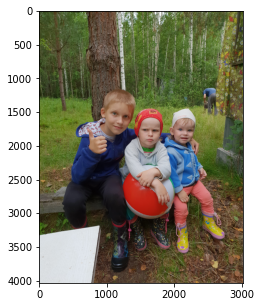

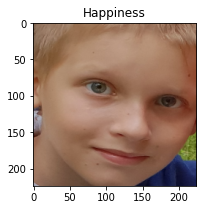

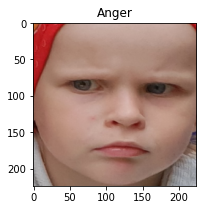

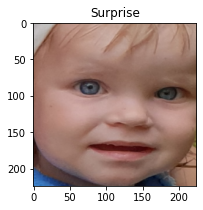

In [13]:
import matplotlib.pyplot as plt
fpath='../test_images/20180720_174416.jpg'
frame_bgr=cv2.imread(fpath)
plt.figure(figsize=(5, 5))
frame = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(frame)
bounding_boxes, points = imgProcessing.detect_faces(frame)
points = points.T
for bbox,p in zip(bounding_boxes, points):
    box = bbox.astype(np.int)
    x1,y1,x2,y2=box[0:4]    
    face_img=frame[y1:y2,x1:x2,:]
    
    face_img=cv2.resize(face_img,INPUT_SIZE)
    inp=face_img.astype(np.float32)
    inp[..., 0] -= 103.939
    inp[..., 1] -= 116.779
    inp[..., 2] -= 123.68
    inp = np.expand_dims(inp, axis=0)
    scores=model.predict(inp)[0]
    plt.figure(figsize=(3, 3))
    plt.imshow(face_img)
    plt.title(idx_to_class[np.argmax(scores)])

In [14]:
imgProcessing.close()